In [1]:
# VAE real data electricity latent space 16 real data

# VAE Autoencoders for non-supervised intrusion detection

Normal Data : Real Data <br>
Attack Data : Real Data <br>
1000 epochs

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline

2022-10-31 16:30:36.361472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 16:30:36.361493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 

In [4]:
path_figures = './figures/'

In [5]:
#path = './data/Zero_Day/'
path = './new_data/'
path_figures = './figures/'
#path_normal = path +'VAE_syntheticdata_normal_epoch100_1000000.csv'
path_normal = path +'normal.csv'
path_attack = path + 'attack.csv' # real data

normal_df = pd.read_csv(path_normal)  
attack_df = pd.read_csv(path_attack)  

normal_df['marker'] = normal_df.apply(label_marker, axis=1)
attack_df['marker'] = attack_df.apply(label_marker, axis=1)

normal_label = normal_df['marker'].to_numpy() 
attack_label = attack_df['marker'].to_numpy() 

print(len(normal_label))
print(len(attack_label))

22714
55663


In [6]:
# Delete marker column 
normal_df.drop(['marker'], axis=1, inplace=True)
attack_df.drop(['marker'], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 128)
attack shape (55663, 128)


In [8]:
normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

In [9]:
attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [10]:
#labels = combine_labels
#norm_samples = df_scaled[labels == 0]  # normal data
#attack_samples = df_scaled[labels == 1]  # attack data

#norm_labels = labels[labels == 0]
#attack_labels = labels[labels == 1]

In [11]:
norm_samples = normal_scaled
attack_samples = attack_scaled
print (attack_samples.shape)
print (norm_samples.shape)

(55663, 128)
(22714, 128)


In [12]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.80 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [13]:
X_train.shape
print(' X_test normal shape',X_test_norm.shape, '\n', 
      'X_test attack shape', X_test_attack.shape, '\n',
      'X_train normal shape', X_train.shape, '\n',
      'X_test shape', X_test.shape)

 X_test normal shape (4543, 128) 
 X_test attack shape (4543, 128) 
 X_train normal shape (18171, 128) 
 X_test shape (9086, 128)


In [14]:
# we use RMSE as reconstruction error (can use MAE as well)
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [15]:
# The reparameterization trick for the autoencoder

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [16]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2) 
latent_dim = int(original_dim / 3) 

#intermediate_dim = 256
latent_dim = 16
print(' original_dim : ', original_dim,'\n',
      'intermediate_dim : ', intermediate_dim, '\n', 
      'latent_dim : ', latent_dim)

 original_dim :  128 
 intermediate_dim :  64 
 latent_dim :  16


In [17]:
# enconder >< decoder
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 32)           2080        ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 16)           528         ['dense_1[0][0]']                
                                                                                            

In [18]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim/2, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
Total params: 10,976
Trainable params: 10,976
Non-trainable params: 0
_________________________________________________________________


In [19]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [20]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [21]:
# Training autoencoder
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)

vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=700,
                        batch_size=32)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128)]             0         
                                                                 
 encoder (Functional)        (None, 16)                11392     
                                                                 
 decoder (Functional)        (None, 128)               10976     
                                                                 
Total params: 22,368
Trainable params: 22,368
Non-trainable params: 0
_________________________________________________________________
Train on 18171 samples
Epoch 1/700
   32/18171 [..............................] - ETA: 2:09 - loss: 551.5085

2022-10-31 16:30:40.537346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:30:40.537643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 16:30:40.537703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-31 16:30:40.537757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-31 16:30:40.539290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

18171/18171 [==============================] - 1s 49us/sample - loss: 262.7453
Epoch 2/700
18171/18171 [==============================] - 1s 36us/sample - loss: 80.3935
Epoch 3/700
18171/18171 [==============================] - 1s 36us/sample - loss: 62.2492
Epoch 4/700
18171/18171 [==============================] - 1s 37us/sample - loss: 56.2716
Epoch 5/700
18171/18171 [==============================] - 1s 36us/sample - loss: 50.6952
Epoch 6/700
18171/18171 [==============================] - 1s 35us/sample - loss: 46.5277
Epoch 7/700
18171/18171 [==============================] - 1s 36us/sample - loss: 42.7632
Epoch 8/700
18171/18171 [==============================] - 1s 36us/sample - loss: 40.2503
Epoch 9/700
18171/18171 [==============================] - 1s 36us/sample - loss: 38.6232
Epoch 10/700
18171/18171 [==============================] - 1s 36us/sample - loss: 37.5580
Epoch 11/700
18171/18171 [==============================] - 1s 36us/sample - loss: 36.4935
Epoch 12/700
18171/

18171/18171 [==============================] - 1s 38us/sample - loss: 18.7086
Epoch 92/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.6392
Epoch 93/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.6244
Epoch 94/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.5525
Epoch 95/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.5387
Epoch 96/700
18171/18171 [==============================] - 1s 38us/sample - loss: 18.4861
Epoch 97/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.4826
Epoch 98/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.4099
Epoch 99/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.3426
Epoch 100/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.2888
Epoch 101/700
18171/18171 [==============================] - 1s 37us/sample - loss: 18.2572
Epoch 102/

18171/18171 [==============================] - 1s 37us/sample - loss: 16.5109
Epoch 181/700
18171/18171 [==============================] - 1s 37us/sample - loss: 16.5194
Epoch 182/700
18171/18171 [==============================] - 1s 38us/sample - loss: 16.4570
Epoch 183/700
18171/18171 [==============================] - 1s 38us/sample - loss: 16.4427
Epoch 184/700
18171/18171 [==============================] - 1s 38us/sample - loss: 16.4305
Epoch 185/700
18171/18171 [==============================] - 1s 37us/sample - loss: 16.4106
Epoch 186/700
18171/18171 [==============================] - 1s 37us/sample - loss: 16.3812
Epoch 187/700
18171/18171 [==============================] - 1s 37us/sample - loss: 16.3969
Epoch 188/700
18171/18171 [==============================] - 1s 38us/sample - loss: 16.3749
Epoch 189/700
18171/18171 [==============================] - 1s 38us/sample - loss: 16.3195
Epoch 190/700
18171/18171 [==============================] - 1s 37us/sample - loss: 16.3976
Ep

18171/18171 [==============================] - 1s 38us/sample - loss: 15.5354
Epoch 270/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.5484
Epoch 271/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.5346
Epoch 272/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.5537
Epoch 273/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.4894
Epoch 274/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.5335
Epoch 275/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.5539
Epoch 276/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.5368
Epoch 277/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.4932
Epoch 278/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.5057
Epoch 279/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.4890
Ep

18171/18171 [==============================] - 1s 38us/sample - loss: 15.1984
Epoch 359/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.1415
Epoch 360/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.2014
Epoch 361/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.1988
Epoch 362/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.1781
Epoch 363/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.1473
Epoch 364/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.1957
Epoch 365/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.2313
Epoch 366/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.2069
Epoch 367/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.1795
Epoch 368/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.2666
Ep

18171/18171 [==============================] - 1s 38us/sample - loss: 15.3916
Epoch 448/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.3103
Epoch 449/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.3762
Epoch 450/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.4228
Epoch 451/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.2940
Epoch 452/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.3804
Epoch 453/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.2895
Epoch 454/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.3499
Epoch 455/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.4075
Epoch 456/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.4376
Epoch 457/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.3703
Ep

18171/18171 [==============================] - 1s 38us/sample - loss: 15.5167
Epoch 537/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.6916
Epoch 538/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.6420
Epoch 539/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.6217
Epoch 540/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.5671
Epoch 541/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.5960
Epoch 542/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.5883
Epoch 543/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.5330
Epoch 544/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.5417
Epoch 545/700
18171/18171 [==============================] - 1s 37us/sample - loss: 15.5811
Epoch 546/700
18171/18171 [==============================] - 1s 38us/sample - loss: 15.5660
Ep

18171/18171 [==============================] - 1s 38us/sample - loss: 276.3013
Epoch 626/700
18171/18171 [==============================] - 1s 38us/sample - loss: 274.4070
Epoch 627/700
18171/18171 [==============================] - 1s 38us/sample - loss: 98.4541
Epoch 628/700
18171/18171 [==============================] - 1s 38us/sample - loss: 46.8486
Epoch 629/700
18171/18171 [==============================] - 1s 39us/sample - loss: 34.9324
Epoch 630/700
18171/18171 [==============================] - 1s 38us/sample - loss: 39.4854
Epoch 631/700
18171/18171 [==============================] - 1s 38us/sample - loss: 19.7300
Epoch 632/700
18171/18171 [==============================] - 1s 38us/sample - loss: 25.4211
Epoch 633/700
18171/18171 [==============================] - 1s 38us/sample - loss: 24.4995
Epoch 634/700
18171/18171 [==============================] - 1s 38us/sample - loss: 151.3466
Epoch 635/700
18171/18171 [==============================] - 1s 37us/sample - loss: 128.038

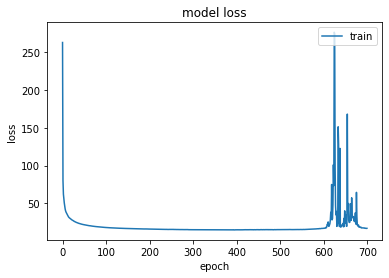

In [22]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [23]:
# Prediction of training vector
X_train_pred = vae_model.predict(X_train)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [24]:
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error \
      {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

error_thresh = np.quantile(mae_vector, 0.97)
print('error threshold >>>', error_thresh)

Avg error 0.020143390397364624
median error       0.016669407819628182
99Q: 0.08635523406791587
error threshold >>> 0.055137684422589546


In [25]:
# application of error threshold in test vector
# A vector of anomalies is created with the points that go over the threshold

X_pred = vae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total length vector anomalies : ',len(anomalies))
print('Number of anomalies : ', np.count_nonzero(anomalies))
print('total length of y_test vector',len(y_test))
print('total lenght of attacks in y_test vector', np.count_nonzero(y_test))

total length vector anomalies :  9086
Number of anomalies :  4716
total length of y_test vector 9086
total lenght of attacks in y_test vector 4543


In [26]:
# Sklearn classification report
print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      4543
         1.0       0.96      1.00      0.98      4543

    accuracy                           0.98      9086
   macro avg       0.98      0.98      0.98      9086
weighted avg       0.98      0.98      0.98      9086



In [27]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = encoder.predict(X_test)

/home/manero/anaconda3/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [28]:
# PCA transformation to observe variance in 2 components


#, svd_solver='arpack'
pca = PCA(n_components=2, random_state=123)
X_transform = pca.fit_transform(X_pred2)

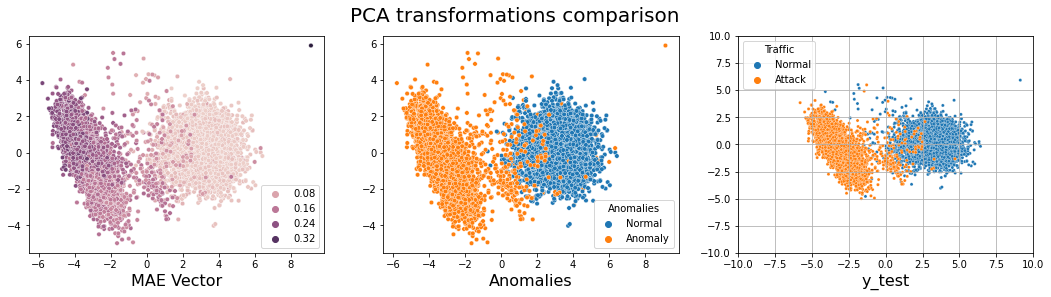

In [29]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Normal', 'Anomaly'], title='Anomalies')
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Normal', 'Attack'], title='Traffic')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.grid()
plt.show()

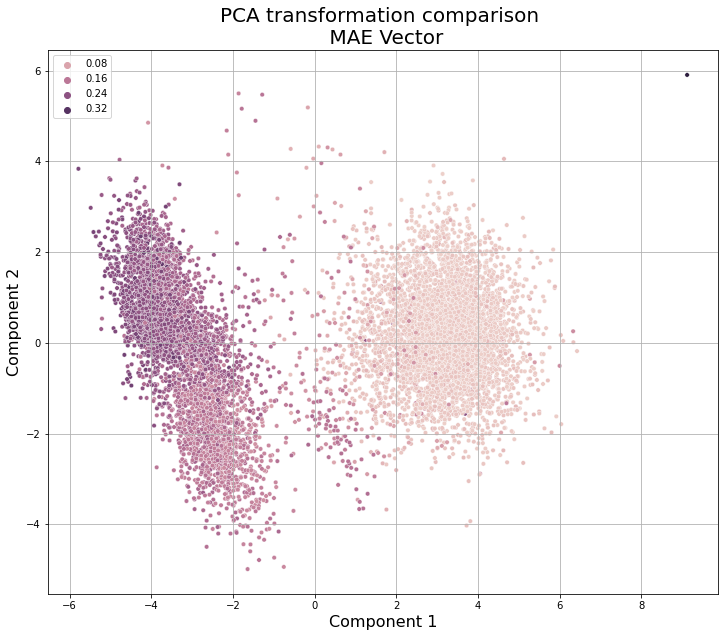

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n MAE Vector',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

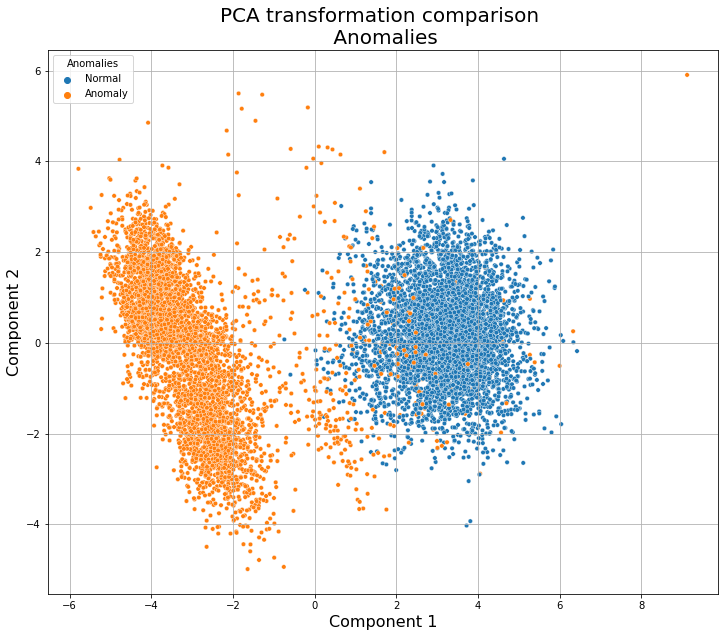

In [31]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n Anomalies',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Anomaly'], title='Anomalies')
plt.grid()
plt.show()

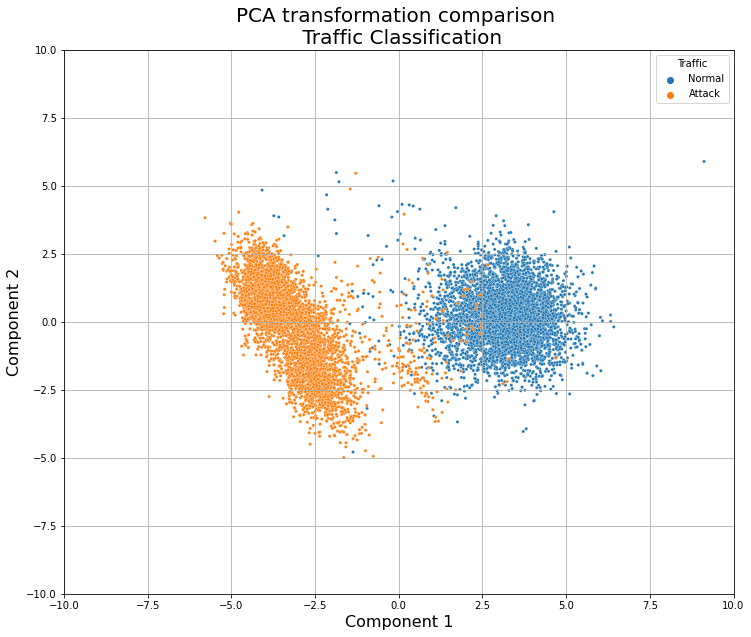

In [32]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('PCA transformation comparison \n Traffic Classification',size=20)
ax.set_ylabel('Component 2', size=16)
ax.set_xlabel('Component 1', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Attack'], title='Traffic')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.grid()
plt.show()

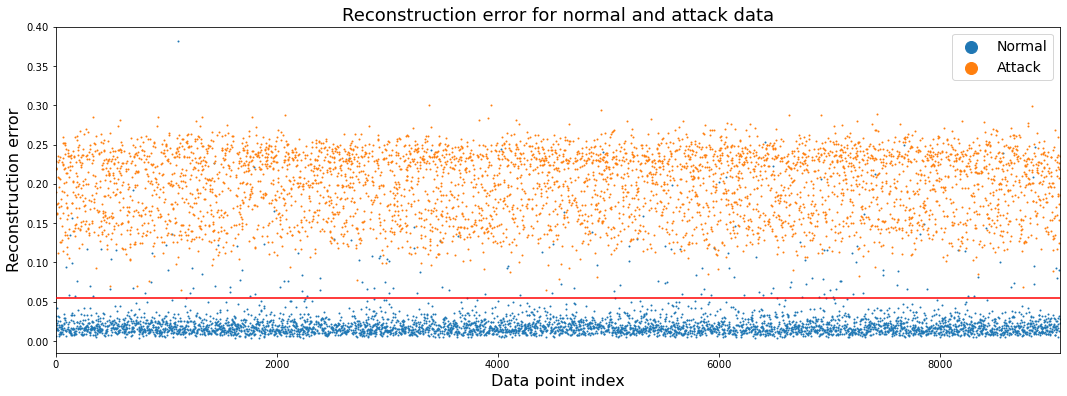

In [33]:
# Reconstruction figure
plt.rc('legend',fontsize=14)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=1, linestyle='',
            label= "Attack" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", 
          zorder=100, label='Threshold')
plt.xlim(0,error_df.shape[0])
# leg = ax.legend()
# leg.set_title('Traffic',prop={'size':14})
plt.legend(legend_label, ['Normal', 'Attack'], prop={'size': 14}, 
          loc="upper right", markerscale=2., scatterpoints=1)
plt.title("Reconstruction error for normal and attack data", size=18)
plt.ylabel("Reconstruction error", size=16)
plt.xlabel("Data point index", size = 16)
plt.show()

In [34]:
# Reconstruction errors for figure

Global_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(' Attack_error shape', Attack_error.shape, '\n', 
      'Normal_error shape', Normal_error.shape)

 Attack_error shape (4543,) 
 Normal_error shape (4543,)


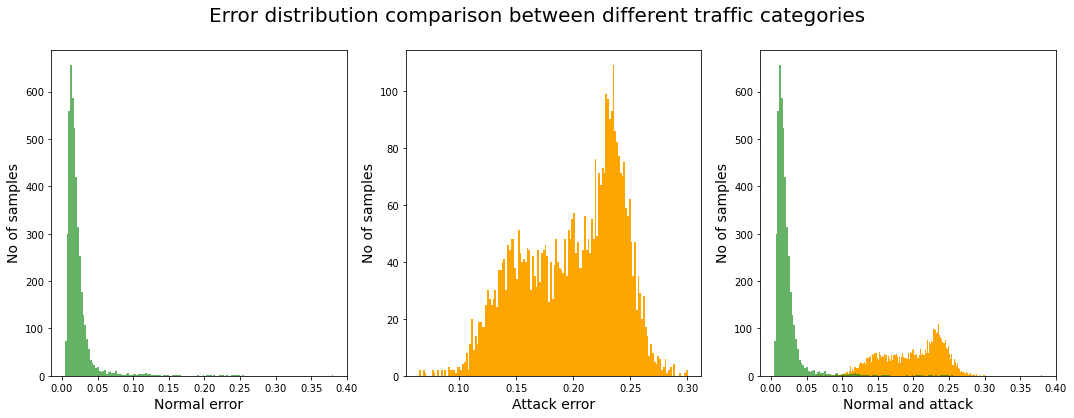

In [35]:
# Figure error distribution

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='orange')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='orange')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

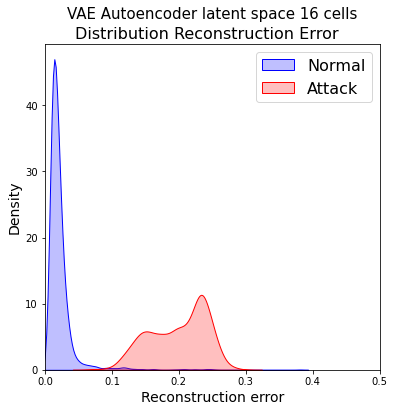

In [44]:
# === Paper Figure ===
# Distribución reconstruction error 
# Distribución reconstruction error 
latent_space = latent_dim
plt.rcParams['axes.titley'] = 1.12

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.kdeplot(
    Normal_error,
    fill    = True,
    ax      = ax,
    label   = 'Normal',
    color   = 'blue'
)
sns.kdeplot(
    Attack_error,
    fill    = True,
    ax      = ax,
    label   = 'Attack',
    color   = 'red'
)
#sns.rugplot(error_reconstruccion,  ax=ax, color='black')
plt.suptitle('Distribution Reconstruction Error',y=0.92, 
            fontsize=16)
ax.set_title('VAE Autoencoder latent space '+str(latent_space)+' cells', fontsize=15)
ax.set_xlabel('Reconstruction error', fontsize = 14);
ax.set_ylabel('Density',fontsize=14);
ax.set_xlim(0,0.5)
plt.legend( fontsize=16)
plt.savefig(path_figures+'VAE_'+str(latent_space)+'_rea_ele.png', dpi=600)
plt.show()

### 

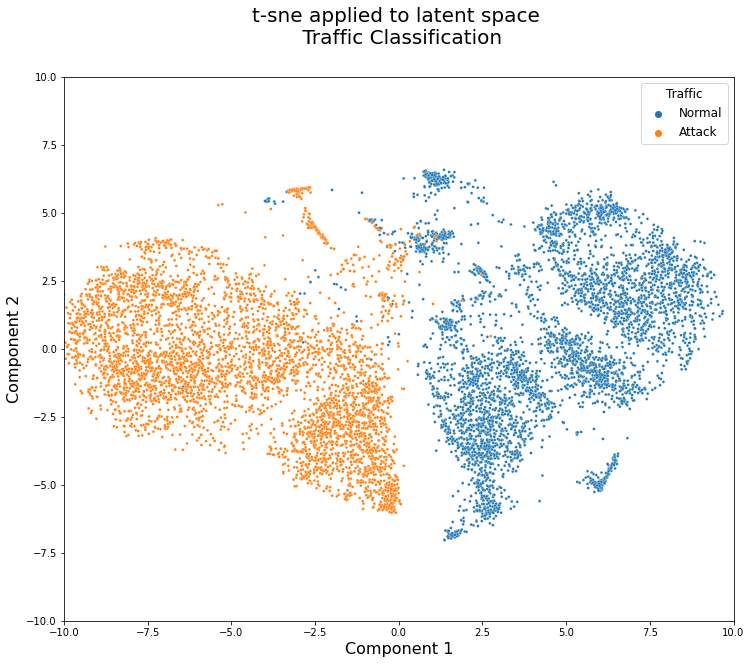

In [37]:
# Analisis latent space with t-SNE

plt.rcParams['axes.titley'] = 1.05
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, init='pca', random_state=123)
tsne_results = tsne.fit_transform(X_pred2)

df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two']) 

fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title('t-sne applied to latent space \n Traffic Classification',size=20)
ax.set_ylabel('Component 2', size=16)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=y_test,
    alpha=1,
    data=df_subset,
    cmap=custom_cmap,
    s = 8
)
ax.set_xlabel('Component 1', size=16)
legend_label, _ = ax.get_legend_handles_labels()
ax.legend(legend_label, ['Normal', 'Attack'], title='Traffic', fontsize=12, title_fontsize=12)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
plt.show()


In [38]:
# t-sne transformation to observe variance in 3 components of latent space

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300, init='pca', random_state=123)
tsne_results = tsne.fit_transform(X_pred2)
plt.rcParams['axes.titlepad'] = -14 
df_subset=pd.DataFrame(tsne_results, columns=['tsne-2d-one','tsne-2d-two', 'tsne-2d-three']) 

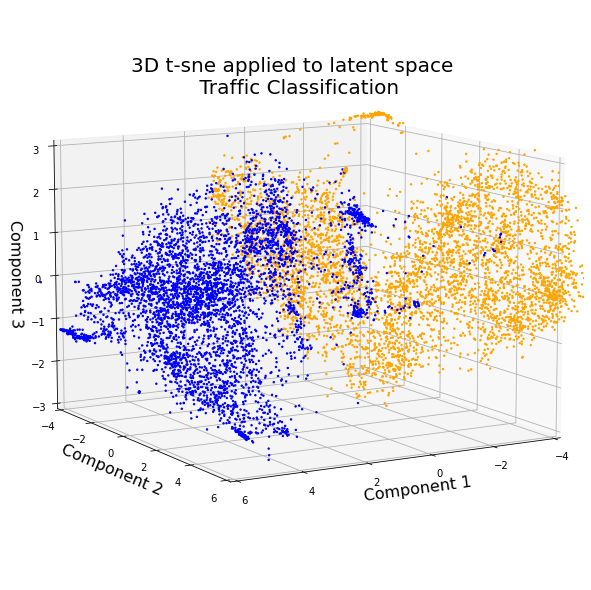

In [39]:
# t-sne figure 3D

plt.rcParams['axes.titley'] = .95

fig = plt.figure(figsize=(8,8))
ax= Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.axes.set_xlim3d(left=-4, right=6)
ax.axes.set_ylim3d(bottom=-4, top=6)
ax.axes.set_zlim3d(bottom=-3, top=3)
custom_cmap = LinearSegmentedColormap.from_list("", ["blue","orange"])
sc = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2],
               c=y_test, alpha = 1, cmap=custom_cmap, s=2)
plt.title('3D t-sne applied to latent space \n Traffic Classification',size=20)

ax.set_xlabel('Component 1', size=16)
ax.set_ylabel('Component 2', size=16)
ax.set_zlabel('Component 3', size=16)
# rotate the axes and update
#fig.tight_layout()
fig.subplots_adjust(left=0, right=1, bottom=-10, top=-2)
ax.view_init(10, 60)
plt.show()

In [40]:
#EOF